In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re

from io import BytesIO
from PIL import Image
import requests
import gensim
from scipy.sparse import coo_matrix, csr_matrix

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

Считываем данные

In [ ]:
books = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture09/HW/BX-Books.csv')

interactions = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture09/HW/BX-Book-Ratings.csv',
                           sep=";", encoding = "ISO-8859-1")

users = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture09/HW/BX-Users.csv', 
                    delimiter=';', encoding = 'ISO-8859-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Предобработка

Удаляем неявные данные (с нулевым рейтингом)

In [ ]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [ ]:
interactions.head()

User-ID        ISBN  Book-Rating
1   276726  0155061224            5
3   276729  052165615X            3
4   276729  0521795028            6
6   276736  3257224281            8
7   276737  0600570967            6

In [ ]:
books.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

In [ ]:
# сколько пользователей поставили рейтинг определенной книге
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})
# сколько книг оценил определенный пользователь
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})
# добавляем эту инфу в датасет
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

del user_meets, books_meets

Удаляем выбросы

In [ ]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

Объединяем с датасетом, описывающим книги

In [ ]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [ ]:
le = LabelEncoder()

interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])
need_user_id = le.classes_

users = users[users['User-ID'].isin(need_user_id)]

In [ ]:
users.head()

User-ID                              Location   Age
7          8              timmins, ontario, canada   NaN
98        99              franktown, colorado, usa  42.0
113      114           ligonier, pennsylvania, usa  57.0
241      242  neuffen, baden-wuerttemberg, germany  37.0
242      243           arden hills, minnesota, usa   NaN

In [ ]:
users.describe()

User-ID          Age
count   10960.000000  7795.000000
mean   138984.878285    35.790763
std     80307.861920    14.493049
min         8.000000     0.000000
25%     69057.750000    26.000000
50%    137977.000000    33.000000
75%    208882.000000    43.000000
max    278854.000000   244.000000

Меняем NaN на средний возраст по каждой локации. Где не смогм поменять на средний по локации - удаляем (теряем не так много)

*наверняка можно сделать значительно оптимальнее*

In [ ]:
# считаем средний возраст по каждой локации
mean_age_for_location = users[users.Age.notnull()].groupby("Location")["Age"].median().reset_index().rename(
    columns={"Age": "NotNull_Age"})

# разделяем датасет на содержащий NaN в возрасте и не содержащий
null_age_users = users[np.invert(users.Age.notnull())]
not_null_age_users = users[users.Age.notnull()]

# меняем все NaN на найденый средний возраст по локации
null_age_users = null_age_users.merge(mean_age_for_location, on=["Location"]).drop(['Age'], axis=1).rename(
    columns={"NotNull_Age": "Age"})

# соединяем все обратно
users = pd.concat([null_age_users, not_null_age_users]).sort_values(by=['User-ID'])

del null_age_users, not_null_age_users, mean_age_for_location

Удалим выбросы по возрасту

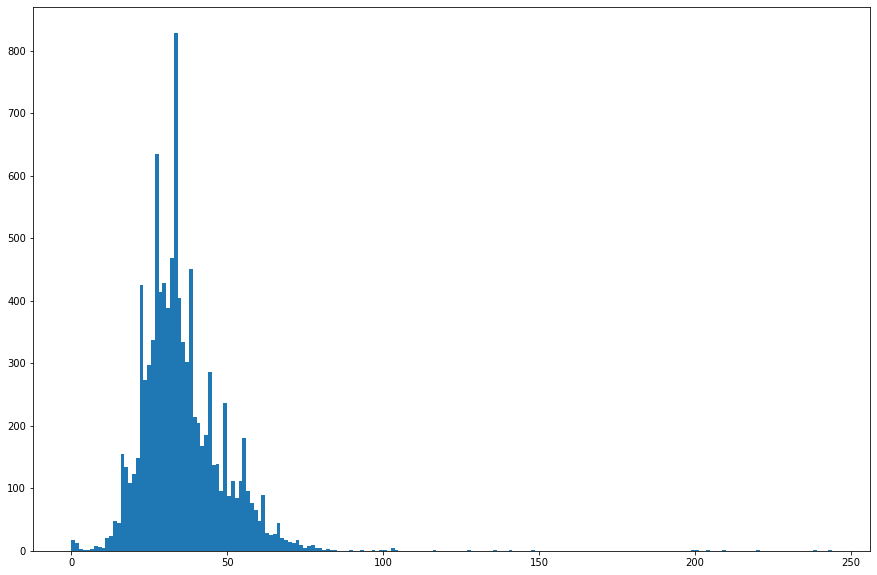

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(users.Age, bins=200);

In [ ]:
users = users[(users["Age"] > 10) & (users["Age"] < 80)]

Нормализуем возраст

In [ ]:
users[["Age"]] = MinMaxScaler().fit_transform(users[["Age"]].values.reshape(-1, 1))

Удаляем пользователей, у которых не получилось определить возраст

In [ ]:
users_uid = users['User-ID'].unique()
interactions = interactions[interactions['User-ID'].isin(users_uid)]

le = LabelEncoder()

interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

### 1. Реализация персонального топа - принимает на вход возраст и локацию, на выходе персональный топ 

Векторизуем локации

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1), binary=True, min_df=3, token_pattern=r'[^\d\W]+\b')
vectorized = vectorizer.fit_transform(users['Location'].values)

vectorized_location = pd.DataFrame(vectorized.astype(np.int8).toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Формируем итоговый датасет

In [ ]:
users_vec = pd.concat([users.reset_index(drop=True), vectorized_location], axis=1).drop(['User-ID', 'Location'], axis=1)
del vectorized, vectorized_location

In [ ]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

Отрисовка

In [ ]:
def rec_imaging(mean_film_rating, film_id, interactions, top_n=10):
  fig = plt.figure(figsize=(30, 15))
  for i, top_id in enumerate(film_id[:top_n]):
    url = interactions.loc[interactions['product_id'] == top_id, 'picture_url'].values[0]
    title = interactions.loc[interactions['product_id'] == top_id, 'Book-Title'].values[0]
    try:
      r = requests.get(url)
      im = Image.open(BytesIO(r.content))
    except:
      print('Something went wrong with {url}'.format(url=i))
      continue
    a = fig.add_subplot(2, 5, i + 1)
    if mean_film_rating[i] is not None:
      a.title.set_text(f'Title = "{title[:30]}"\n raiting = {mean_film_rating[i]}\n Book_id = {top_id}\n.')
    plt.imshow(im)
    plt.axis('off')
  plt.show()

Расчет топа

In [ ]:
def top_books(user_id, users, csr_rates, interactions, minpts=100):
  # minpts дано свыше
  neigh = NearestNeighbors(n_neighbors=minpts)
  neigh.fit(users)
  # формируем minpts кластеров
  top_neigh = neigh.kneighbors([users.iloc[user_id]], return_distance=False)

  csr_matrix = csr_rates.toarray()[top_neigh[0]]
  # подсчитаем среднюю оценку ближайшего кластера по книгам
  sum_films_rating = csr_matrix.sum(axis=0)
  ratings_number = 1*(csr_matrix != 0).sum(axis=0)

  # Чтобы считать оценку, нужно хотя-бы 2 отзыва (хороший средний рейтинг)
  ratings_number[ratings_number < 2] = -1
  sum_films_rating = sum_films_rating/ratings_number
  mean_film_rating = np.sort(sum_films_rating[sum_films_rating > 0])[::-1]
  film_id = np.argsort(sum_films_rating)[:-(mean_film_rating.size + 1):-1]

  print(f'Personal books top for user {user_id}: \n')
  rec_imaging(mean_film_rating, film_id, interactions)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


Personal books top for user 42: 



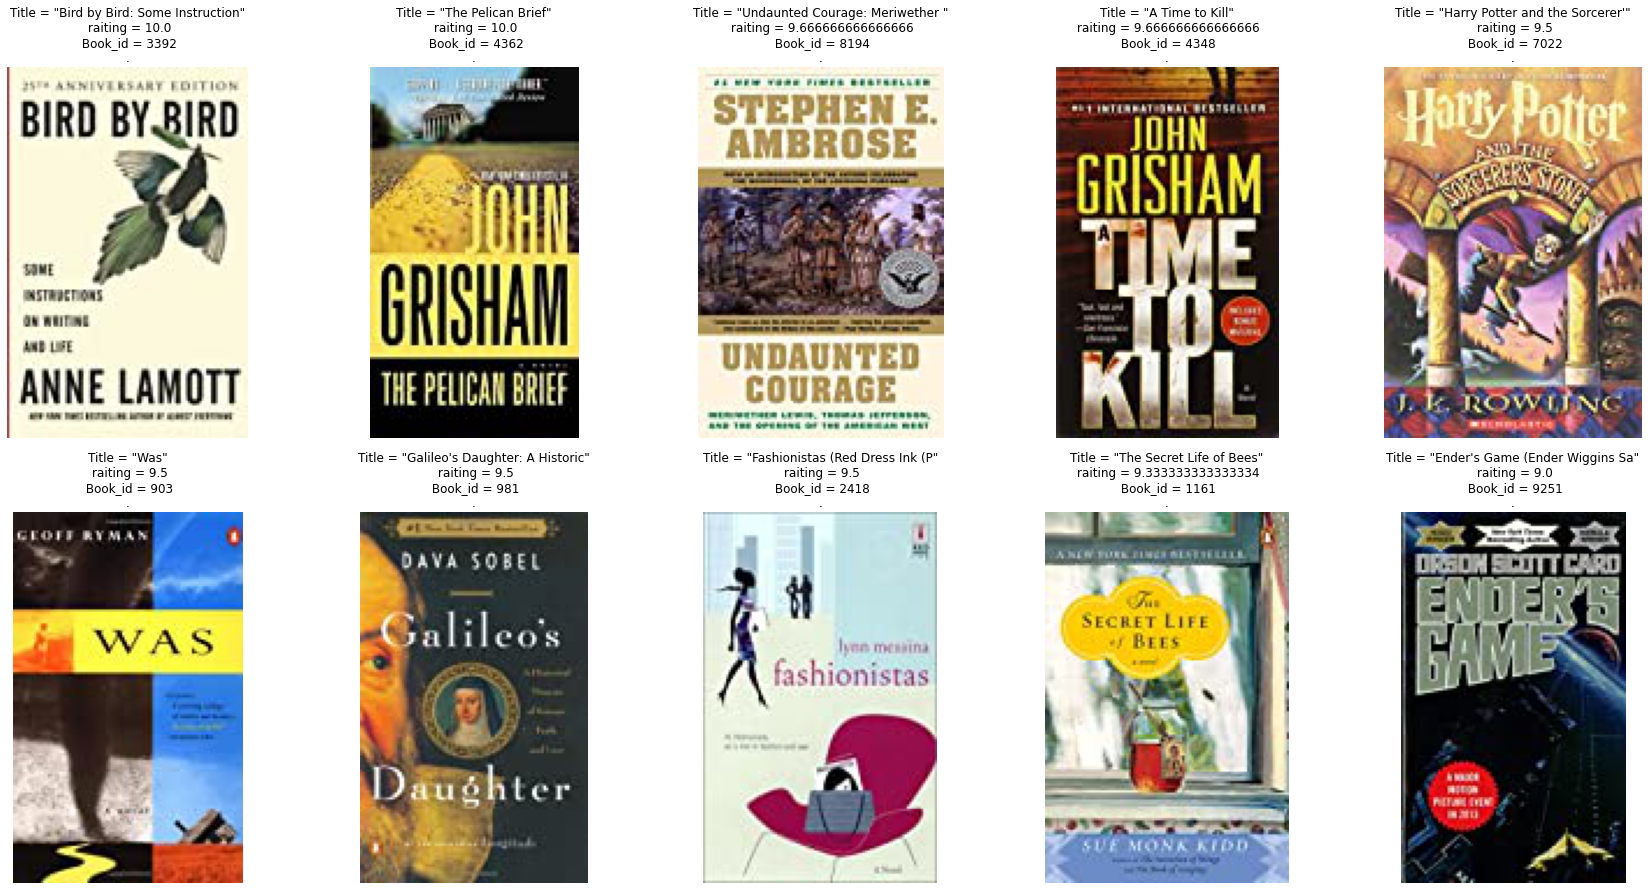

In [ ]:
top_books(42, users_vec, csr_rates, interactions, minpts=100)

### 2. На основе метода кластеризации похожих пользователей построить рекомендации

Добавляем в датасет новые признаки (прочитанные и оцененные книги) 

In [ ]:
interest_features = pd.DataFrame.sparse.from_spmatrix(csr_rates/csr_rates.toarray().max())
users_vec_2 = pd.concat([users_vec, interest_features], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Personal books top for user 42: 



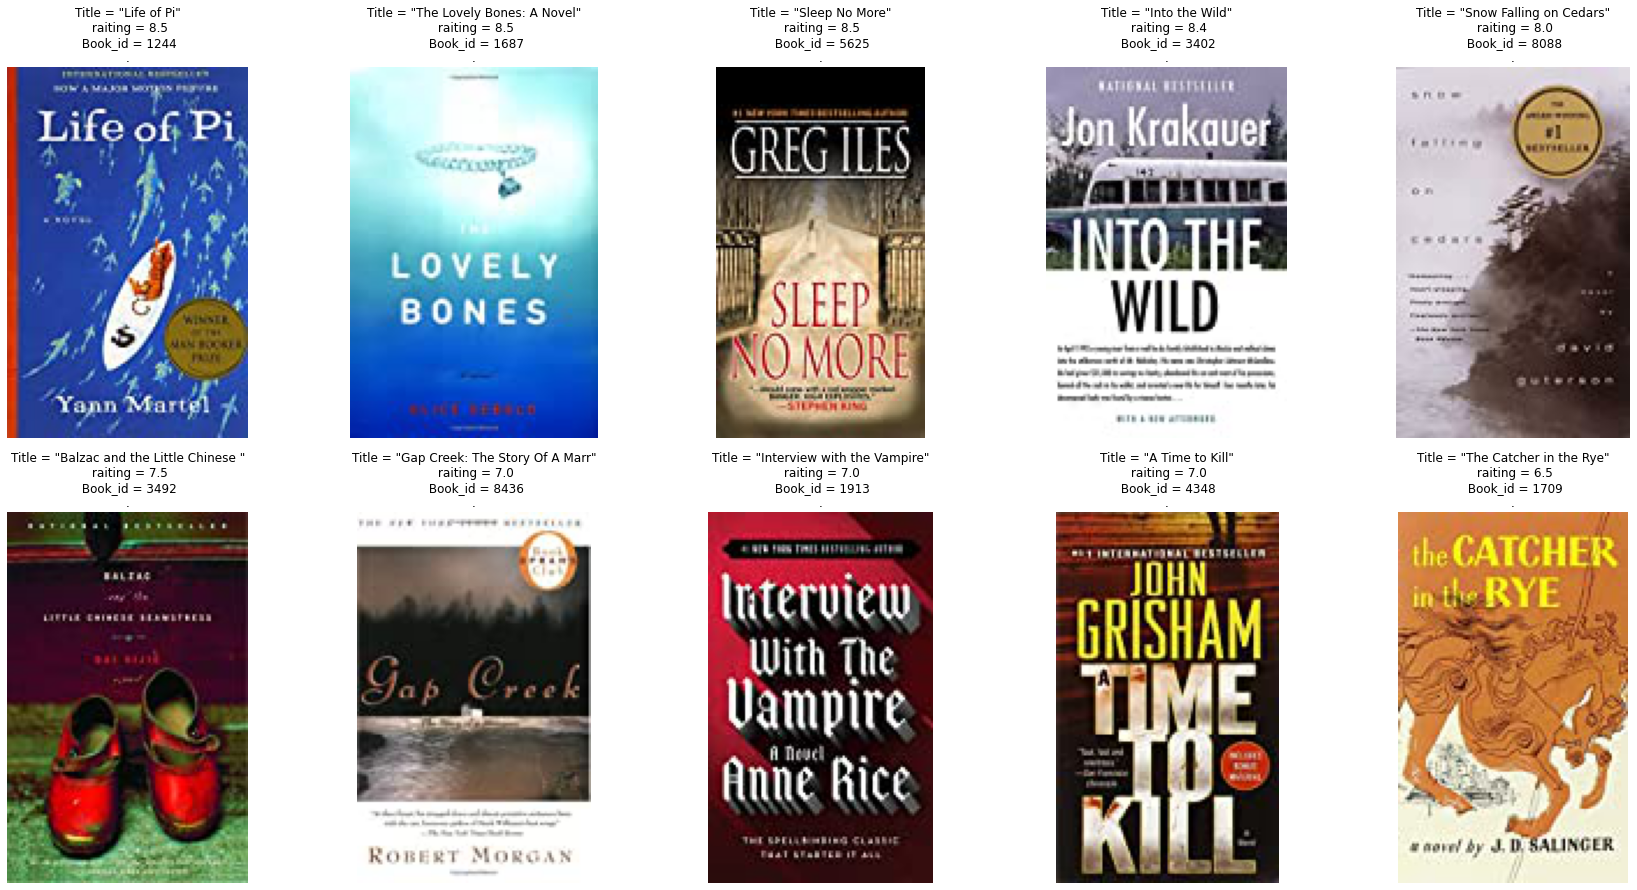

In [ ]:
top_books(42, users_vec_2, csr_rates, interactions, minpts=100)

### 3. Совстречаемость

In [ ]:
def chunks(l, n):
  for i in range(0, len(l), n):
    yield l[i:i + n]

def rec_imag(product_ids, content_dict, measure=None, top_n=5):
  picture_urls = [content_dict[i] for i in product_ids]
  cnt = 0
  for idx, chunk in enumerate(chunks(picture_urls, top_n)):
    fig = plt.figure(figsize=(20, 4))
    for n, i in enumerate(chunk):
      try:
        r = requests.get(i)
        im = Image.open(BytesIO(r.content))

      except:
        print('Something went wrong with {url}'.format(url=i))
        continue

      a = fig.add_subplot(1, top_n, n + 1)
      if measure is not None:
        a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
        cnt += 1
      plt.imshow(im)
      plt.axis('off')
    plt.show()

In [ ]:
class Recomendations():
  def __init__(self, Int):
    # Создаём словарь для того, чтобы по product_id возвращать url товара
    self.product_id_to_url = {}
    for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
        self.product_id_to_url[i[0]] = i[1]
    self.interactions = Int
        
  def coocurrency_count(self):
    Int = self.interactions[["vid", "product_id", "Book-Rating"]].drop_duplicates()
    # Для каждого пользователя собираем товары, с которыми он взамиодействовал
    # не забываем учитывать оценки
    user_products = pd.concat([Int.groupby(["vid"])["product_id"].apply(list).reset_index(),
                                Int.groupby(["vid"])["Book-Rating"].apply(list).reset_index()['Book-Rating']], axis=1)
    # Считаем число товаров, с которыми взаимодействовал каждый пользователь и записываем в колонку prod_num
    product_num = [len(i) for i in user_products["product_id"]]
    user_products["prod_num"] = product_num
    # Фильтруем пользователей, взаимодействовавших с одним товаром
    user_products = user_products[user_products["prod_num"] > 1]
    
    # Заводим словарь под товары
    cooc = {}
    for i in tqdm.tqdm_notebook(user_products.values):
      for j in range(len(i[1])):
        for k in range(len(i[1])):
          if j != k:
            try:
              # полусумма оценок
              cooc[str(i[1][j]) + "_" + str(i[1][k])] += (i[2][j] + i[2][k])/2 
            except:
              cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1

    cooc_list = []
    for i, j in cooc.items():
      # Если товары встетились вместе больше одного раза, то добавляем в список
      if j != 1:
          cooc_list.append(i.split("_") + [j])
    self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
  
  def get_rec(self, i, show=False):
    recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                        .sort_values("measure", ascending=False)\
                        .head(10)
    print(u"Для товара")
    rec_imag([i], self.product_id_to_url)
    print(u"Такие рекомендации")
    rec_imag(recs["item2"].values.astype(int), self.product_id_to_url, 
                      recs["measure"].values.astype(int))

In [ ]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8827 [00:00<?, ?it/s]

Для товара


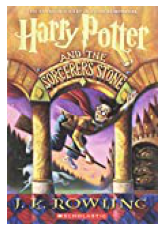

Такие рекомендации


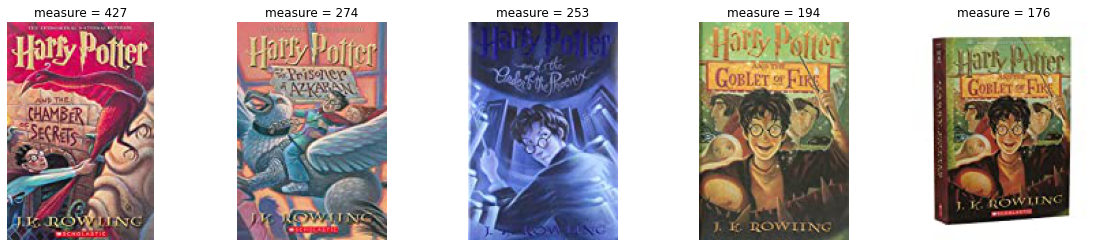

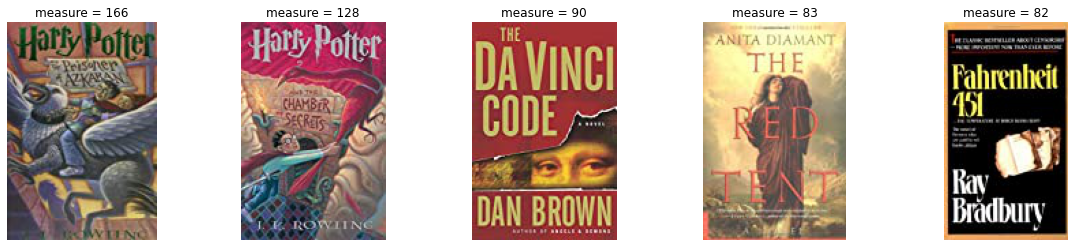

In [ ]:
cooc_rec.get_rec(7022)

### 4. Коллаборативная фильтрация

In [ ]:
class Colloborative():
  
  def __init__(self, interactions, csr_rates):
      self.content_dict = {}
      for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
          self.content_dict[int(i)] = j
      
      self.csr_rates = csr_rates        

  def user_based(self, idx):
    csr_rates_matrix = self.csr_rates.toarray().copy().astype(float)
    # чтобы нуль остался нулем после преобразований
    csr_rates_matrix[csr_rates_matrix == 0] = np.nan
    # рейтинг конкретного пользователя
    user_rates = csr_rates_matrix[idx]
    # отнимаем от рейтингов средние значения оценок
    correct_rates = csr_rates_matrix - np.nanmean(csr_rates_matrix, axis=1).reshape(-1, 1)
    # возвращаем нули
    correct_rates = np.nan_to_num(correct_rates)
    csr_rates_matrix = np.nan_to_num(csr_rates_matrix)
    user_rates_mean = np.nan_to_num(np.nanmean(user_rates))
    user_rates = np.nan_to_num(user_rates)
    
    watched_items = np.where(user_rates != 0)[0]
    # считаем косинус между пользователем idx и всеми пользователями
    metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
    # домножаем оценки пользователя на коэффициент похожести
    rates = correct_rates * metrics

    total_rate = (1 - user_rates.astype(bool)) * (user_rates_mean 
                                                  + np.sum(rates, axis=0)/np.sum(metrics))
    # печатаем рекомендации
    self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                np.sort(total_rate)[::-1][:10])
      
  def item_based(self, idx):
    csr_rates_matrix = self.csr_rates.toarray().copy().astype(float)
    # чтобы нуль остался нулем после преобразований
    csr_rates_matrix[csr_rates_matrix == 0] = np.nan
    # рейтинг конкретной книги
    item_rates = csr_rates_matrix[:, idx]
    # отнимаем от рейтингов средние значения оценок
    correct_rates = csr_rates_matrix.T - np.nanmean(csr_rates_matrix, axis=1).reshape(1, -1)
    # возвращаем нули
    correct_rates = np.nan_to_num(correct_rates)
    csr_rates_matrix = np.nan_to_num(csr_rates_matrix)
    item_rates_mean = np.nan_to_num(np.nanmean(item_rates))
    item_rates = np.nan_to_num(item_rates).reshape(1, -1)

    # считаем косинус между товаром idx и всеми пользователями
    metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
    # домножаем оценки книги на коэффициент похожести
    rates = correct_rates * metrics
    
    total_rate = (item_rates_mean + np.sum(rates, axis=1)/np.sum(metrics))
    # печатаем рекомендации
    self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                np.sort(total_rate)[::-1][:10])
    
    

  def get_rec(self, watched, recs, measure):
    print(u"Для таких товаров")
    rec_imag([i for i in watched], self.content_dict)
    print(u"Такие рекомендации")
    rec_imag([i for i in recs], self.content_dict, measure)

In [ ]:
clb = Colloborative(interactions, csr_rates)

Для таких товаров


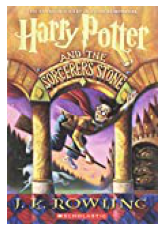

Такие рекомендации


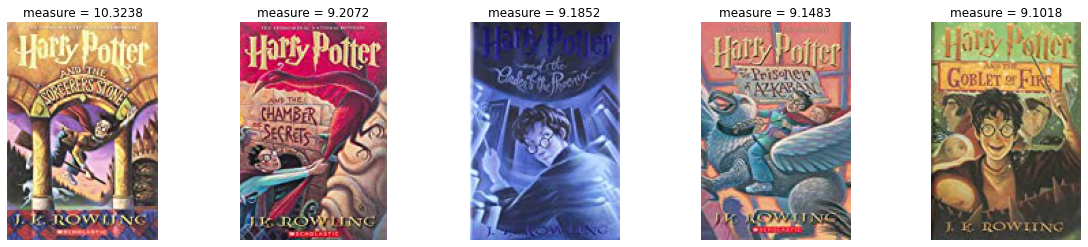

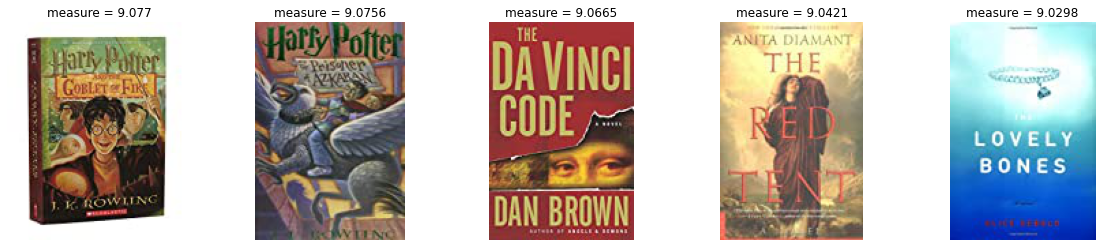

In [ ]:
clb.item_based(7022)

Для таких товаров


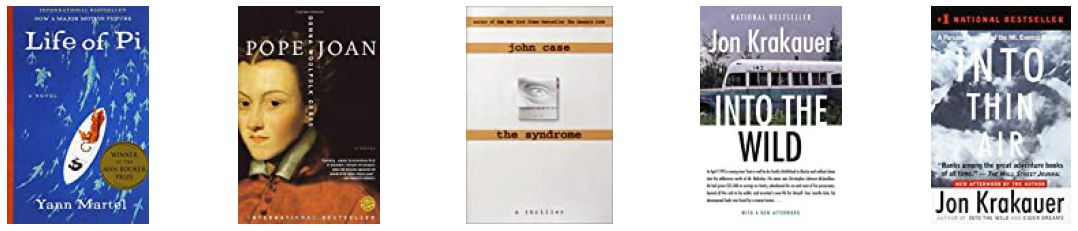

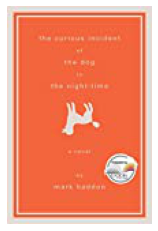

Такие рекомендации


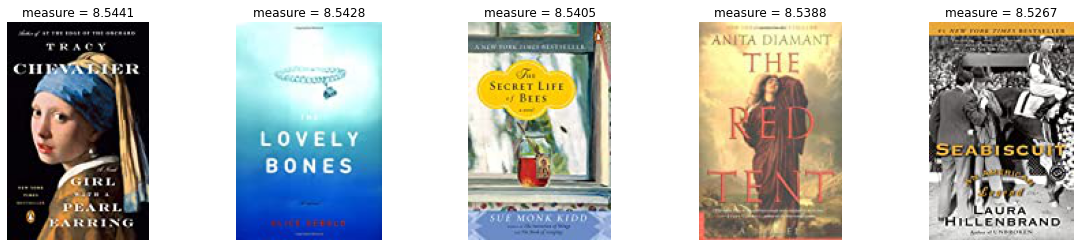

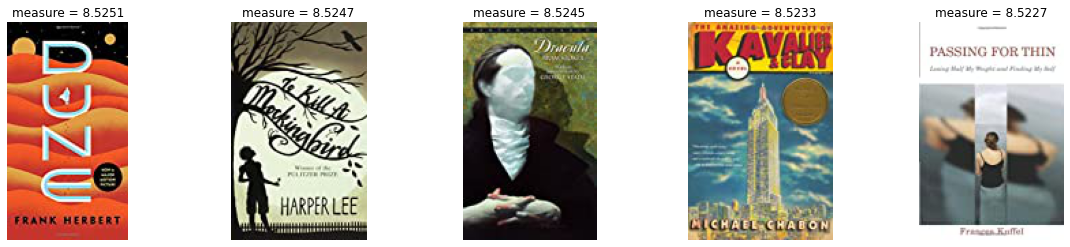

In [ ]:
clb.user_based(42)